In [5]:
#| code-fold: true

import numpy as np
import scipy.stats
import scipy.linalg

import matplotlib.pyplot as plt

from functools import reduce

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

from pyqsp.angle_sequence import QuantumSignalProcessingPhases

import contextlib
import io

def quiet(func):
    def quiet_func(*args, **kwargs):    
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            res = func(*args, **kwargs)
        return res
    return quiet_func

# Introduction

Quantum singular value transformation (QSVT) is a new framework developed in recent years that is now extensively used to understand and improve existing as well as construct new quantum algorithms. If you are willing to be bit dramatic, QSVT has been claimed to provide a grand unification of many different quantum algorithms. So, how does this work?

## A high-level overview
Constructing a quantum algorithm using QSVT consists the following main steps. Don't worry if this does not make sense at the moment, the goal of this post is to fill in the details and give examples.

1. Reduce your problem of interest to transforming singular values of some matrix $A$.
2. Find a unitary circuit $U$ that is a block-encoding of your matrix, i.e. in a suitable basis $$U=\begin{pmatrix}A&*\\ *&*\end{pmatrix} \ .$$
3. If the goal is to transform singular values $\sigma_i$ of $A$ by some function $f(\sigma_i)$, find an appropriate polynomial approximation $p(x)\approx f(x)$.
4. Using quantum signal processing construct a circuit $U_\phi$ that involves as much applications of $U$ as the degree of $p(x)$ and block-encodes approximation the answer, i.e.
$$U_\phi=\begin{pmatrix}p(A)&*\\*&*\end{pmatrix}$$
Here $p(A)$ has singular values $p(\sigma_i)$ but we don't yet give its precise definition.

Let's start with clarifying the first step, i.e. how to frame your quantum problem as a singular value transformation, by giving three examples.

1. **Grover's search.** There is some marked state $|m\rangle$ of $n$ qubits that wee need to find. In this case we can take $A$ to be $1\times 1$ matrix containing a single matrix element $a=\langle m|H^{\otimes n}|0\rangle$. If we can apply the step-function to it $x\to \theta(x-b)$, we will map an arbitrary amplitude $a>b$ to 1, and hence build the circuit that is guaranteed to take the initial state $|0\rangle$ to the marked state $|m\rangle$.
1. **Quantum simulation.** Here given a Hamiltonian $H$ we seek to construct a unitary $e^{-iHt}$. This is literally the problem of the eigenvalue transformation, because $e^{-iHt}$ is by definition the matrix $H$ with eigenvalues $\lambda_i$ mapped to $e^{-i\lambda_i t}$. Up to technicalities, eigenvalues can be transformed in the same way as singular values.
1. **Solving linear equations.** Given a matrix $A$ and a vector $b$ solve $Ax=b$ for $x$, i.e. compute $A^+b$ where $A^+$ is Moore-Penrose pseudo-inverse of $A$. But pseudo-inverse $A^+$ is just equal to the usual hermitian conjugate $A^\dagger$ with reciprocal singular values $\sigma_i\to \sigma_i^{-1}$.

Many other applications of QSVT exist, but in this blog post I will focus on these ones. So hopefully step (1) is starting to make sense now. How do we perform step (2) then, how to find the block-encoding? To my understanding, this may be the most challenging step that has to be addressed case-by-case. I will give some intuition and examples of block-encodings below. Next, QSVT allows to directly perform only polynomial transformations, but most problems of practical interest require applying non-polynomial functions to singular values. This is why we need step (3), which is finding the right polynomial approximation. Interestingly, the degree of the approximating polynomial determines the complexity of the final quantum circuit, so this is an important step. Finally, after you found the polynomial transformation approximating your target function you use techniques of the quantum signal processing to prepare the corresponding quantum circuit. Generally, constructing the circuit for a given polynomial is quite under control, although there still may be issues with speed and numerical stability for large instances.

## What I will and will not discuss

...

# Quantum signal processing

The origin and application of the quantum signal processing (QSP) are very interesting in their own right, but I won't review them here. Instead, I will view QSP as a rudimentary version of QSVT applied to two-level systems, and hence it is a great starting point.

So, suppose you have a two-level system and can perform a simple diagonal transformation on it
$$S(\phi)=\begin{pmatrix}e^{i\phi}&0 \\ 0& e^{-i\phi}\end{pmatrix} \ . \label{S}$$
Here $\phi$ is an angle you can vary. You can also perform a fixed non-diagonal operation
$$R(a)=\begin{pmatrix}a&\sqrt{1-a^2}\\\sqrt{1-a^2} & -a\end{pmatrix} \ . \label{R}$$
Here $a\in \mathbb{R}$ is fixed.

The most general quantum circuit you can build is by interleaving these two as follows

$$U_\phi =S(\phi_0)\prod_{i=1}^d R(a) S(\phi_i) = S(\phi_0)R(a) S(\phi_1) R(a)\dots S(\phi_{d-1}) R(a) S(\phi_d) \label{QSP} \ .$$

The explicit form of $U_\phi$ will be as follows
$$U_\phi=i^d\begin{pmatrix} p(a) & i q(a)\sqrt{1-a^2} \\ i q(a)^*\sqrt{1-a^2} & -p(a)^*\end{pmatrix} \ . $$
Importantly, here $p(a)$ and $q(a)$ are *polynomials*.

# Various stuff

- A word about svd -- completely general, nice applications to many thigs, e.g. pseudo-inverse

# Quantum signal processing

Define the basic setup of quantum signal processing.
- Implementing arbitrary polynomials subject to conditions.
- Measure in $|\pm\rangle$ basis.
- Automated way to find phases.

In [4]:
def R(a):
    """Singla operator in R-convention"""
    
    b = np.sqrt(1-a**2)
    W = np.array([
        [a, b],
        [b, -a]])

    return W

def Sz(phi):
    return np.diag([np.exp(1j*phi), np.exp(-1j*phi)])

def angles_from_Wx_to_R(phis):
    assert len(phis)>0, 'At least one angle must be provided.'
    phis = \
    [phis[0]+(2*len(phis)-3)*np.pi/4] \
    + [phi-np.pi/2 for phi in phis[1:-1]] \
    + [phis[-1]-np.pi/4]
    
    return phis 

def apply_QSP(w, phis):
    """Computes S(phi_0) @ w @ s(phi_1) @ w ... @ S(phi_d-1) @ w @ S(phi_d)."""
    
    phis = angles_from_Wx_to_R(phis)
    
    res = Sz(phis[-1])
    for phi in phis[:-1][::-1]:        
        res = Sz(phi) @ w @ res
    
    return res

Exercise: implement polynomial by phases.

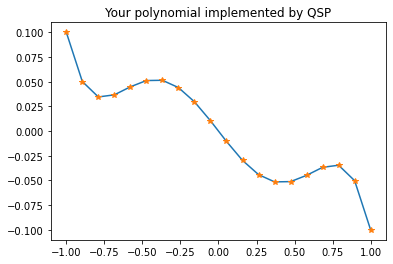

In [5]:
# An excersize.

def polynomial_value(coeffs, x):
    """ Computes c[0]*x**0 + c[1]*x**1+...+c[n]*x**n. """
    x = np.array([x])
    return (np.array(coeffs) * x**np.arange(len(coeffs))).sum()

# Som arbitrary set of polynomial coefficiets.
# Must define even or odd polynomial p(x) that satisfies p(x)<1 for -1<x<1. 

coeffs =  [0., -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 20)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

# Compute matrix elements of the QSP sequence
unitaries = [apply_QSP(R(xi), phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

# QSVT

- Block embedding in the computational basis
$$U=\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}$$
- For a single-qubit embedding $U=|0\rangle \langle0|\otimes A+\dots$.
- More generally, there is some basis change $B_L, B_R$ that leads to the standard block-encoding
$$U=B_L\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}B_R$$
With any such basis we associated projectors $\Pi_L=B_L\left(|0\rangle\langle0|\otimes \mathbb{1} \right)B_L^\dagger $ which satisfy
$$\Pi_L U \Pi_R = B_L\begin{pmatrix}A&0\\0&0\end{pmatrix}B_R$$
- We need access to 
$$\Pi_L(\phi)=e^{(2\Pi_L-\mathbb{I})\phi}=B_L \begin{pmatrix}e^{i\phi}&0\\ 0&e^{-i\phi}\end{pmatrix}B_L^\dagger$$

Then, the main statement of QSVT is the following. A bit awkwardly, it needs to be split in two cases. First consider when the polynomial is even (the number of phases is odd)

$$U_{\phi}=\prod_{i=0}^{d/2-1}\Pi_R(\phi_{2i})U^\dagger\Pi_L(\phi_{2i+1})U$$
When the polynomial is odd (the number of phases even)

$$U_{\phi}=\Pi_L(\phi_{0})U\prod_{i=1}^{(d-1)/2}\Pi_R(\phi_{2i-1})U^\dagger\Pi_L(\phi_{2i})U$$

In [6]:
def projector_rotation(P, phi):
    n = len(P)
    return np.eye(n)*np.cos(phi)-1j*(2*P-np.eye(n))*np.sin(phi)


def apply_QSVT(U, PL, PR, phis):
    
    phi_last = phis[-1]
    
    if len(phis) % 2 == 1: # Even polynomial
        phis_paired = phis[:-1]
        phi_0 = None
    else: # Odd polynomial
        phis_paired = phis[1:-1]
        phi_0 = phis[0]
    
    res = projector_rotation(PR, phi_last)
    
    for phi_R, phi_L in np.array(phis_paired).reshape(-1, 2)[::-1]:
        res =  projector_rotation(PR, phi_R) @ U.conj().T @  projector_rotation(PL, phi_L) @ U @ res
    
    if phi_0 is not None:
        res = projector_rotation(PL, phi_0) @ U @ res
        
    return res

# Amplitude amplification

Encompasses
1. Grover's search.
1. Oblivious amplitude amplification.
1. Used in other quantum algorithms.

## Test

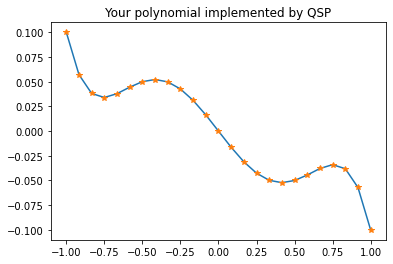

In [7]:
P = np.diag([1, 0])


coeffs =  [0, -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
phis = angles_from_Wx_to_R(phis)

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 25)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

unitaries =[apply_QSVT(R(xi), P, P, phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

## Poly test

In [8]:
target_function = pyqsp.poly.PolySign()

coeffs_list = []
vals = []
for N in range(1, 100)[::1]:
    degree = np.ceil(np.sqrt(N))
    if degree % 2 == 0:
        degree += 1
        
    coeffs, scale = quiet(target_function.generate)(
        degree, 
        delta=2*np.sqrt(N), 
        ensure_bounded=True, 
        return_scale=True);
    
    coeffs_list.append(coeffs)
    vals.append(polynomial_value(coeffs, 1/np.sqrt(N)))

## Implementation

In [9]:
np.random.seed(42)


def projector_from_state(state):
    return np.outer(state, state.conj())


amplitudes = []
for num_qubits in range(1, 11):
    
    N = 2**num_qubits
    
    # Define initial state |0> and the associated projector.
    all_zero_state = np.zeros(N)
    all_zero_state[0] = 1
    PR = projector_from_state(all_zero_state)

    # Define a random marked state. It will only be accessed via the corresponding projector.
    marked_state = np.zeros(N)
    marked_state[np.random.randint(0, N)] = 1
    PL = projector_from_state(marked_state)

    # Signal operator is the n-th tensor power of the Hadamard gate.
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    U = reduce(np.kron, [H]*num_qubits)

    
    target_function = pyqsp.poly.PolySign()
    
    degree = np.ceil(N**0.5)
    if degree % 2 == 0:
        degree += 1
    
    delta = N**0.5
    coeffs, scale =  quiet(target_function.generate)(degree, delta=delta, return_scale=True)

    phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
    phis = angles_from_Wx_to_R(phis)

    U_phi = apply_QSVT(U, PL, PR, phis)
    amplitude = np.max(np.abs(np.real(PL @ U_phi @ PR)))
    
    amplitudes.append(amplitude)

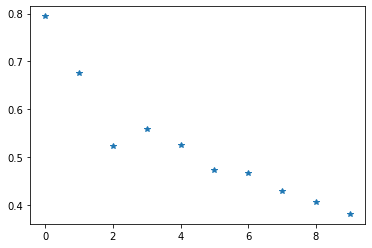

In [10]:
plt.plot(amplitudes, '*')

# Hamiltonian simulation

We are given three things

1. Block embedding of a Hamiltonian $H$, i.e. $U$ s.t. $H=\left(\langle 0|\otimes I \right)U\left(|0\rangle\otimes I\right)$.
2. Projectors $\Pi(\phi)$.
3. ??


## Block encodings

Singular value $\sigma$ are positive square roots of eigenvalues $M^\dagger M\ge0$.

To block encode some matrix $M$ we need $||M||\le1$ where $||\cdot||$ is the operator norm or, equivalently, the largest singular value.

In [146]:
class BlockEncoding:
    
    def __init__(self, M):
        
        self.num_rows = M.shape[0]
        self.num_cols = M.shape[1]
        self.dim = 2*self.block_dimension(max(self.num_cols, self.num_rows))
        
        self.diagonal_block = self.pad_matrix(M, self.dim//2)
        
        U, S, WH = np.linalg.svd(self.diagonal_block)
        
        self.U = U
        self.S = S
        self.WH = WH
        
        self.off_diagonal_block = self.make_off_diagonal_block(self.U, self.S, self.WH)
        
        self.unitary = self.unitary_from_blocks(
            self.diagonal_block, 
            self.off_diagonal_block)
        
        self.projector = np.kron(np.diag([1, 0]), np.eye(self.dim//2))
 
    @staticmethod
    def block_dimension(n):
        """Finds the minimum number of qubits to block encode a square matrix of dimension n"""
        return int(2**np.ceil(np.log2(n)))
        
    @staticmethod
    def pad_matrix(M, dim):
        """Pads a matrix with zeros make to make it into a d x d matrix.."""
        
        S = np.zeros((dim, dim), dtype=np.complex64)
        n_rows, n_cols = M.shape
        S[:n_rows,:n_cols] = M
        return S
    
    @staticmethod
    def make_off_diagonal_block(u, s, wh):
        assert np.all(s<=1), f'All singular values {s} must be less than 1.'
        return u @ np.diag(np.sqrt(1-s**2)) @ wh
    
    @staticmethod
    def unitary_from_blocks(A, B):
        n = A.shape[0]
        U = np.zeros((2*n, 2*n), dtype=np.complex64)
        U[:n, :n] = A
        U[:n,n:2*n] = B
        U[n:2*n, :n] = B
        U[n:2*n, n:2*n] = -A
        
        assert np.allclose(U @ U.conj().T, np.eye(2*n), atol=1e-5), 'Ops, block encoding is not unitary.'
        return U

## Implementation

- Success probability depends on the details of block encoding. 
- We assume $0\le spec(H)\le 1$.
- In our case we build bloc-encoding of $\frac12 e^{-i H t}$ and the algorithm successed with $\frac14$ chance.
- $C(e^{i\phi}U)=C(U)\cdot S\otimes I$




Firts let's build the polynomials and angles sequences.

In [151]:
seed = 42
np.random.seed(seed)

num_qubits = 6
N = 2**num_qubits

V = scipy.stats.unitary_group.rvs(N, random_state=seed)
D = np.random.uniform(low=0, high=1, size=(N,))

H = V*D @ V.conj().T

block_encoding = BlockEncoding(H)
U = block_encoding.unitary
P = block_encoding.projector

In [152]:
costx = pyqsp.poly.PolyCosineTX()
sintx = pyqsp.poly.PolySineTX()

t = np.arange(1, 10)
epsilon = 0.01

norms = []
degrees = []
for ti in t:

    U_phi = []
    degree = 0
    
    for target_function in [costx, sintx]:
        coeffs = quiet(target_function.generate)(tau=ti, epsilon=epsilon)
        phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
        phis = angles_from_Wx_to_R(phis)
        degree += len(phis)-1

        U_phi.append(apply_QSVT(U, P, P, phis))
    
    degrees.append(degree)
    
    U_phi_cos, U_phi_sin = U_phi
    H_cos = U_phi_cos[:N, :N]+U_phi_cos[:N, :N].conj().T
    H_sin = U_phi_sin[:N, :N]+U_phi_sin[:N, :N].conj().T
    H_transformed = H_cos -1j*H_sin
    
    norm = np.linalg.norm(H_transformed-scipy.linalg.expm(-1j*H*ti))
    norms.append(norm)

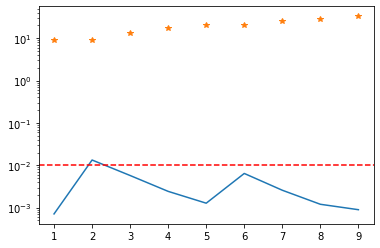

In [153]:
plt.plot(t, norms)
plt.axhline(epsilon, color='red', linestyle='--', label='error threshold')
plt.plot(t, degrees, '*')
plt.yscale('log')

# Solving linear systems

- Given a linear system $Ax=b$ compute $x=A^+b$.
- $A^+$ is pseudo-inverse. If $A=\sum_{\sigma_i\neq 0} \sigma_i |v_i\rangle\langle w_i|$ then $A^+=\sum_{\sigma_i\neq 0} \sigma_i^{-1} |w_i\rangle\langle v_i|$.

## Implementation

In [300]:
seed = 1
np.random.seed(seed)

num_qubits = 3
N = 2**num_qubits
kappa = 3

b = np.random.uniform(size=(N,))
b = b/(np.sqrt((b**2).sum()))

n, m = np.random.randint(N//2, N, size=2)
V = scipy.stats.ortho_group.rvs(n, random_state=seed**2)
W = scipy.stats.ortho_group.rvs(m, random_state=seed**3)

singular_values = np.random.uniform(low=1/kappa, high=1, size=min(n, m))
Sigma = np.zeros((n, m))
Sigma[:min(n, m), :min(n, m)] = np.diag(singular_values)

A = V @ Sigma @ W.conj().T

block_encoding = BlockEncoding(A)
U = block_encoding.unitary
P = block_encoding.projector

In [301]:
epsilon = 0.1

target_function = pyqsp.poly.PolyOneOverX()
coeffs, scale = target_function.generate(kappa=3, epsilon=epsilon, ensure_bounded=True, return_scale=True)

phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
phis = angles_from_Wx_to_R(phis)

U_phi = apply_QSVT(U, P, P, phis)

b=30, j0=14
[PolyOneOverX] minimum [-3.5325637] is at [-0.20530335]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  4.24568213e+00  0.00000000e+00 -6.14813187e+01
  0.00000000e+00  5.70160728e+02  0.00000000e+00 -3.77110116e+03
  0.00000000e+00  1.86774294e+04  0.00000000e+00 -7.07245446e+04
  0.00000000e+00  2.06037512e+05  0.00000000e+00 -4.61025085e+05
  0.00000000e+00  7.86778785e+05  0.00000000e+00 -1.01130011e+06
  0.00000000e+00  9.59305607e+05  0.00000000e+00 -6.49556764e+05
  0.00000000e+00  2.96436030e+05  0.00000000e+00 -8.15921088e+04
  0.00000000e+00  1.02215704e+04]


In [257]:
Aplus = np.linalg.pinv(A)
_, s_, _ = np.linalg.svd(Aplus)
np.sort(s)

array([0.00000000e+00, 0.00000000e+00, 3.84951538e-14, 1.54056732e-01,
       1.79116368e-01, 2.04367253e-01, 2.30939100e-01, 3.01179168e-01])

In [364]:
seed = 1
np.random.seed(seed)

num_qubits = 6
N = 2**num_qubits
epsilon = 0.2

target_function = pyqsp.poly.PolyOneOverX()
norms = []
kappas = np.linspace(2, 4, 10)
alphas = []
degrees = []

for kappa in kappas:

    n, m = np.random.randint(N//2, N, size=2)
    V = scipy.stats.ortho_group.rvs(n, random_state=seed**2)
    W = scipy.stats.ortho_group.rvs(m, random_state=seed**3)

    singular_values = np.random.uniform(low=1/kappa, high=1, size=min(n, m))
    Sigma = np.zeros((n, m))
    Sigma[:min(n, m), :min(n, m)] = np.diag(singular_values)

    A = V @ Sigma @ W.conj().T

    block_encoding = BlockEncoding(A)
    U = block_encoding.unitary
    P = block_encoding.projector
    

    coeffs, scale = quiet(target_function.generate)(
        kappa=kappa, 
        epsilon=epsilon, 
        ensure_bounded=True, 
        return_scale=True)
    
    phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
    phis = angles_from_Wx_to_R(phis)
    
    degrees.append(len(coeffs)-1)
    
    U_phi = apply_QSVT(U, P, P, phis)
    
    exact_pseudo_inverse = np.linalg.pinv(A)
    our_pseudo_inverse = 2*kappa*np.real(U_phi.conj().T)[:m, :n] 
    
    norm = np.linalg.norm(our_pseudo_inverse-exact_pseudo_inverse, ord=2)
    norms.append(norm)

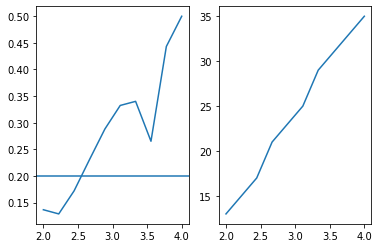

In [365]:
plt.subplot(1, 2, 1)
plt.plot(kappas, norms)
plt.axhline(epsilon)
plt.subplot(1, 2, 2)
plt.plot(kappas, degrees)

# Chebyshev polynomials

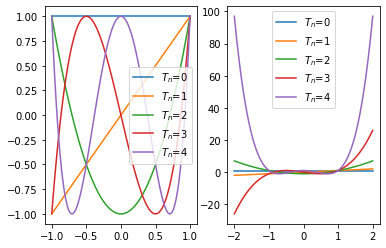

In [376]:
plt.subplot(1, 2, 1)
x = np.linspace(-1, 1, 100)
for n in range(5):
    plt.plot(x, plt.np.polynomial.Chebyshev.basis(n)(x), label=f'$T_n$={n}')
plt.legend();
plt.subplot(1, 2, 2)
x = np.linspace(-2, 2, 100)
for n in range(5):
    plt.plot(x, plt.np.polynomial.Chebyshev.basis(n)(x), label=f'$T_n$={n}')
plt.legend();
